In [1]:
#imports

import requests
from requests import get
from bs4 import BeautifulSoup as MySoup
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from time import sleep
from random import randint

#Scrape IMDB top 1000 movies

headers = {"Accept-Language": "en-US, en;q=0.5"}

Name = []
Director =[]
Released_date =[]
Genre =[]
IMDB_rate =[]
Runtime =[]
Votes =[]
Gross_amount =[]


for page in range(1,1000,100): #range(1,10001,50):
    page = requests.get("https://www.imdb.com/search/title/?groups=top_1000&sort=user_rating,desc&count=100&start=" + str(page) + "&ref_=adv_nxt", headers=headers)
    bs_data = MySoup(page.text, 'html.parser')
    #bs_data
    movies=bs_data.findAll('div', class_='lister-item mode-advanced')
    sleep(randint(2,10))
    for comb in movies:
        title = comb.h3.a.text #Name of the movies
        Name.append(title)
        year = comb.find('span',{'class':'lister-item-year text-muted unbold'}).text
        Released_date.append(year)
        time=comb.find('span',{'class':'runtime'}).text if comb.p.find('span', class_='runtime') else '-'
        Runtime.append(time)
        rate=float(comb.find('div',{'class':'inline-block ratings-imdb-rating'})['data-value'])
        IMDB_rate.append(rate)
        drc= comb.find('p',{'class':''}).a.text
        Director.append(drc)
        nv = comb.find_all('span', attrs={'name': 'nv'})
        vote=nv[0].text
        Votes.append(vote)
        gross=nv[1].text if len(nv) > 1 else '-'
        Gross_amount.append(gross)
        gnr = comb.find('span',{'class':'genre'}).text[1:]
        Genre.append(gnr)
   
    
    

In [2]:
#Dataframe
top1000 = pd.DataFrame({
'Title': Name,
'Director':Director,
'Released_date': Released_date,
'Genre': Genre,
'Runtime': Runtime,
'Rating': IMDB_rate,
'Votes': Votes,
'Gross_mln': Gross_amount,
})

top1000['Released_date'] = top1000['Released_date'].str.extract('(\d+)').astype(int)
top1000['Runtime'] = top1000['Runtime'].str.extract('(\d+)').astype(int)
top1000['Votes'] = top1000['Votes'].str.replace(',', '').astype(int)
top1000['Gross_mln'] = top1000['Gross_mln'].map(lambda x: x.lstrip('$').rstrip('M'))
top1000['Gross_mln'] = pd.to_numeric(top1000['Gross_mln'], errors='coerce')

In [3]:
#number of columns and rows
top1000.shape

(1000, 8)

In [4]:
#first 6 rows
top1000.head(6)

,Title,Director,Released_date,Genre,Runtime,Rating,Votes,Gross_mln
0,Dara of Jasenovac,Predrag Antonijevic,2020,"Drama, War",130,9.7,39342,NaN
1,The Shawshank Redemption,Frank Darabont,1994,Drama,142,9.3,2344986,28.34
2,The Godfather,Francis Ford Coppola,1972,"Crime, Drama",175,9.2,1621842,134.97
3,The Dark Knight,Christopher Nolan,2008,"Action, Crime, Drama",152,9.0,2304991,534.86
4,The Godfather: Part II,Francis Ford Coppola,1974,"Crime, Drama",202,9.0,1130905,57.30
5,12 Angry Men,Sidney Lumet,1957,"Crime, Drama",96,9.0,690558,4.36


In [5]:
#find NAN values
top1000.isnull().sum()

Title              0
Director           0
Released_date      0
Genre              0
Runtime            0
Rating             0
Votes              0
Gross_mln        170
dtype: int64

In [6]:
top1000.loc[top1000['Gross_mln'].isnull(),['Title','Gross_mln']]

,Title,Gross_mln
0,Dara of Jasenovac,NaN
20,Soorarai Pottru,NaN
30,Hara-Kiri,NaN
32,It's a Wonderful Life,NaN
33,Hamilton,NaN
...,...,...
993,Blow-Up,NaN
995,Breakfast at Tiffany's,NaN
996,Giant,NaN
998,Lifeboat,NaN


In [7]:
#replace NaN values with space
top1000.Gross_mln = top1000.Gross_mln.fillna("")

In [8]:
top1000.isnull().sum()

Title            0
Director         0
Released_date    0
Genre            0
Runtime          0
Rating           0
Votes            0
Gross_mln        0
dtype: int64

In [9]:
#Combine all words into one text file for defining the most common word
Title = ' '.join([text for text in top1000['Title']])

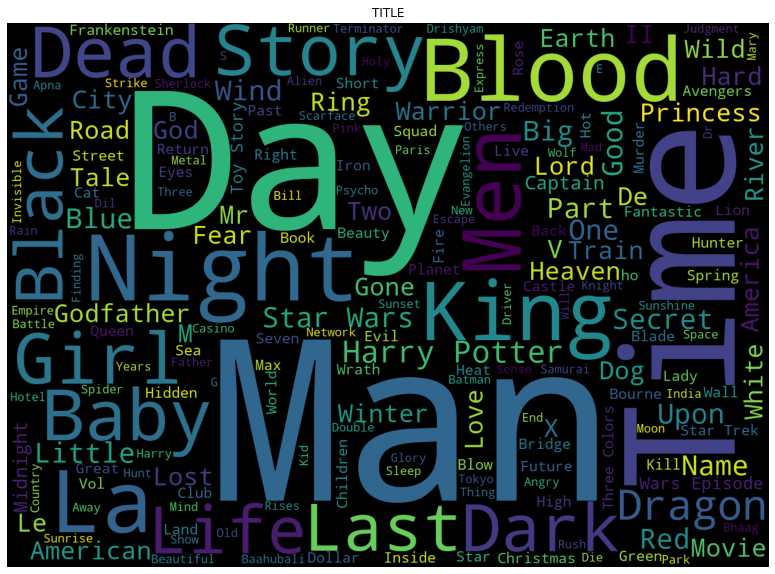

In [10]:
#Title analysis-The most common words
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS
text = (str(top1000['Title']))
plt.subplots(figsize=(14,10))
wordcloud = WordCloud(
                          stopwords=STOPWORDS,
                          width=1400,
                          height=1000
                         ).generate(Title)


plt.imshow(wordcloud)
plt.title('TITLE')
plt.axis('off')
plt.show()

In [11]:
#Genre analysis
top1000['Genre'].value_counts()

Drama                                    84
Drama, Romance                           37
Comedy, Drama                            35
Comedy, Drama, Romance                   31
Action, Crime, Drama                     30
                                         ..
Action, Adventure, Family                 1
Crime, Drama, Sci-Fi                      1
Adventure, Comedy, War                    1
Comedy, Family, Fantasy                   1
Drama, History, Music                     1
Name: Genre, Length: 202, dtype: int64

In [12]:
#Find each unique genre and counts
unique_genre=['Action','Adventure','Animation','Biography','Comedy','Crime','Drama',
             'Fantasy','Family','History','Horror','Music','Musical','Mystery','Romance',
             'Sci-Fi','Sport','Thriller','War','Western']
for i in unique_genre:
    df = top1000['Genre'].str.contains(i).fillna(False)
    print(i,  "-", len(top1000[df]))

Action - 189
Adventure - 196
Animation - 82
Biography - 109
Comedy - 233
Crime - 208
Drama - 724
Fantasy - 67
Family - 56
History - 56
Horror - 32
Music - 47
Musical - 17
Mystery - 99
Romance - 125
Sci-Fi - 67
Sport - 19
Thriller - 137
War - 51
Western - 20


Text(0.5, 1.0, 'TOP 10 DIRECTORS')

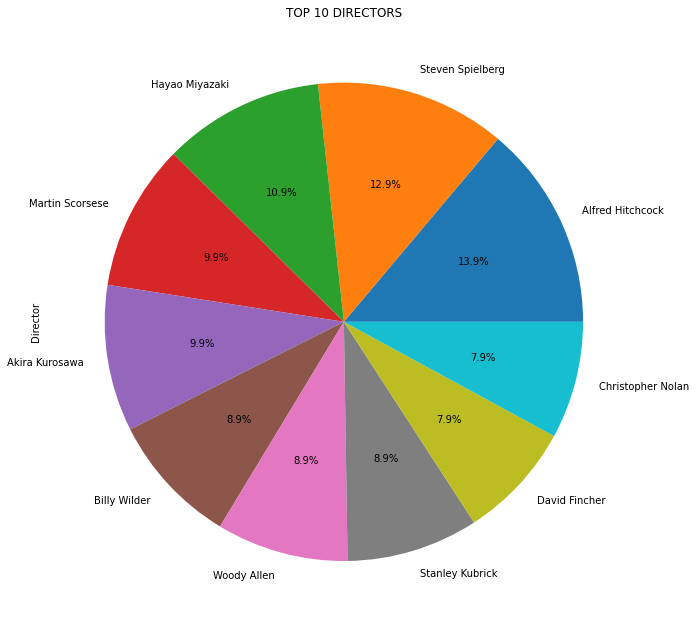

In [13]:
#Director Analysis pie chart
top1000.Director.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(11,11))
plt.title('TOP 10 DIRECTORS')

In [14]:
#Year Analysis
top1000['Released_date'].value_counts()

2004    32
2014    31
2009    29
2016    28
2013    28
        ..
1926     1
1924     1
1922     1
1921     1
1920     1
Name: Released_date, Length: 99, dtype: int64

Text(0.5, 1.0, 'TOP 10 runtime OF MOVIES')

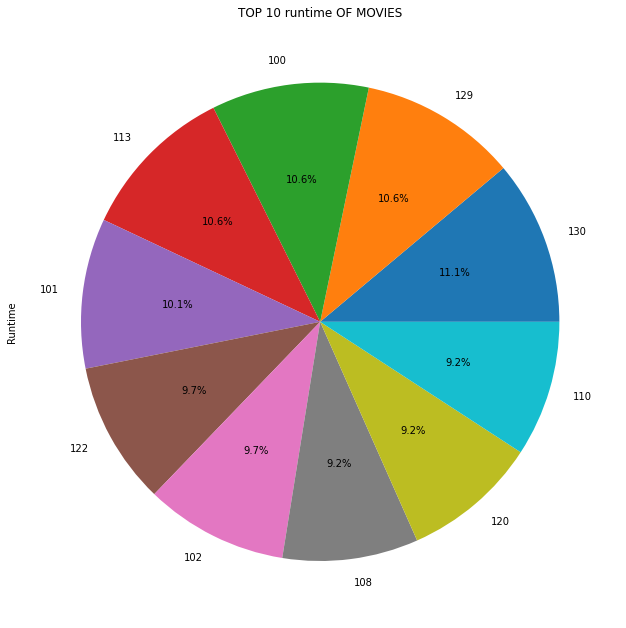

In [15]:
#pie chart for top 10 runtime of movies
top1000.Runtime.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(11,11))
plt.title('TOP 10 runtime OF MOVIES')

c:\python_project\pp\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\python_project\pp\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


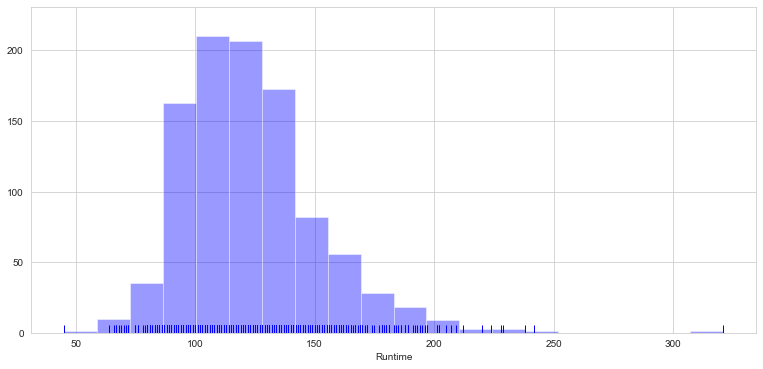

In [16]:
#Runtime distribution
from scipy.stats import norm
time=top1000.Runtime
sns.set_style('whitegrid') 
plt.figure(figsize=(13, 6))
sns.distplot(time, bins=20, kde=False, rug=True, color ='blue');

In [17]:
#Each rating count
top1000['Rating'].value_counts()

7.7    157
7.8    151
8.0    142
8.1    127
7.6    122
7.9    106
8.2     67
8.3     43
8.4     31
8.5     21
8.6     14
8.7      5
8.8      5
8.9      3
9.0      3
9.3      1
9.7      1
9.2      1
Name: Rating, dtype: int64

In [18]:
#find top 10 greatest Rating movies
Sort= top1000.sort_values(['Rating'], ascending=False)
Sort.head(10)

,Title,Director,Released_date,Genre,Runtime,Rating,Votes,Gross_mln
0,Dara of Jasenovac,Predrag Antonijevic,2020,"Drama, War",130,9.7,39342,
1,The Shawshank Redemption,Frank Darabont,1994,Drama,142,9.3,2344986,28.34
2,The Godfather,Francis Ford Coppola,1972,"Crime, Drama",175,9.2,1621842,134.97
3,The Dark Knight,Christopher Nolan,2008,"Action, Crime, Drama",152,9.0,2304991,534.86
4,The Godfather: Part II,Francis Ford Coppola,1974,"Crime, Drama",202,9.0,1130905,57.3
5,12 Angry Men,Sidney Lumet,1957,"Crime, Drama",96,9.0,690558,4.36
6,The Lord of the Rings: The Return of the King,Peter Jackson,2003,"Action, Adventure, Drama",201,8.9,1643898,377.85
7,Pulp Fiction,Quentin Tarantino,1994,"Crime, Drama",154,8.9,1827679,107.93
8,Schindler's List,Steven Spielberg,1993,"Biography, Drama, History",195,8.9,1214397,96.9
11,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,2001,"Action, Adventure, Drama",178,8.8,1662711,315.54


In [19]:
#Votes greater than 1000000
Sort_votes= top1000.sort_values(['Votes'], ascending=False)
Greater_votes= Sort.query('(Votes > 1000000)')
len(Greater_votes)

43

In [20]:
Greater_votes

,Title,Director,Released_date,Genre,Runtime,Rating,Votes,Gross_mln
1,The Shawshank Redemption,Frank Darabont,1994,Drama,142,9.3,2344986,28.34
2,The Godfather,Francis Ford Coppola,1972,"Crime, Drama",175,9.2,1621842,134.97
3,The Dark Knight,Christopher Nolan,2008,"Action, Crime, Drama",152,9.0,2304991,534.86
4,The Godfather: Part II,Francis Ford Coppola,1974,"Crime, Drama",202,9.0,1130905,57.3
6,The Lord of the Rings: The Return of the King,Peter Jackson,2003,"Action, Adventure, Drama",201,8.9,1643898,377.85
7,Pulp Fiction,Quentin Tarantino,1994,"Crime, Drama",154,8.9,1827679,107.93
8,Schindler's List,Steven Spielberg,1993,"Biography, Drama, History",195,8.9,1214397,96.9
11,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,2001,"Action, Adventure, Drama",178,8.8,1662711,315.54
12,Forrest Gump,Robert Zemeckis,1994,"Drama, Romance",142,8.8,1810820,330.25
10,Fight Club,David Fincher,1999,Drama,139,8.8,1856250,37.03
